# Predicting Ski Resort Lift Ticket Prices
### By Group 28

## Introduction

* provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
* clearly state the question you tried to answer with your project
* identify and describe the dataset that was used to answer the question

Lift ticket prices have been rising rapidly with the increasing costs of running ski resorts. This is a result of higher maintenance and operation costs as well as higher wages for the employees at ski resorts. Moreover, there is an increased demand for skiing and snowboarding, leading to more competitive markets, resulting in higher lift ticket prices. A European Commission report published in 2021 shows the average daily lift ticket price for the 2019/2020 ski season was €54 per day in Europe. Compared to the last season, this represents an increase of 4%, and from 10 years ago it represents an increase of 18%. 

The dataset contains six features: 
- **Highest Point**
- **Lowest Point**
- **Total Slope**
- **Total Lifts**
- **Lift Capacity**
- **Snow Cannons**

Through this analysis, we aim to gain insight into the impact of these features on the prices and the relation they each have with it. This study is particularly important as understanding the relation between these variables and lift ticket prices can help consumers make more informed decisions about when and where to ski or snowboard, and can help them identify opportunities to save money on lift tickets. Furthermore, this analysis provides an opportunity for newly established resorts to gain insights into consumer behavior and patterns and set fair market prices accordingly. 

**Steps**: 
- Data wrangling and cleaning
- Exploratory data analysis 
- Data analysis with K-NN regression
- Data visualization 

## Methods & Results

* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
* your report should include code which:
  - loads data from the original source on the web 
  - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
  - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  - performs the data analysis
  - creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

### Attaching Libraries

In [1]:
# Run First
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ recipes      1.0.1     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::st

### Reading and Cleaning Data

In [2]:
# Reading the Data
url <- "https://raw.githubusercontent.com/alextdart/dsci100-group28-2022wt2/main/European_Ski_Resorts.csv"
raw_data <- read_csv(url, show_col_types = FALSE)

# Removing Unneeded Columns (Resort Name and Row Number)
ski_data <- raw_data |>
    select(HighestPoint:SnowCannons)

### Exploratory Data Analysis

In [10]:
# Summary
summary(ski_data)

  HighestPoint   LowestPoint     DayPassPriceAdult BeginnerSlope   
 Min.   :   0   Min.   :   0.0   Min.   : 0.00     Min.   :  0.00  
 1st Qu.:1550   1st Qu.: 779.2   1st Qu.:34.00     1st Qu.:  8.00  
 Median :2104   Median :1050.0   Median :42.00     Median : 19.00  
 Mean   :2052   Mean   :1055.1   Mean   :40.78     Mean   : 35.87  
 3rd Qu.:2568   3rd Qu.:1350.0   3rd Qu.:49.00     3rd Qu.: 40.00  
 Max.   :3899   Max.   :2180.0   Max.   :81.00     Max.   :312.00  
 IntermediateSlope DifficultSlope     TotalSlope      Snowparks        
 Min.   :  0.00    Min.   :  0.00   Min.   :  0.00   Length:376        
 1st Qu.:  9.00    1st Qu.:  2.00   1st Qu.: 25.00   Class :character  
 Median : 22.00    Median :  5.00   Median : 48.00   Mode  :character  
 Mean   : 38.35    Mean   : 11.78   Mean   : 86.26                     
 3rd Qu.: 42.25    3rd Qu.: 13.00   3rd Qu.:100.00                     
 Max.   :239.00    Max.   :103.00   Max.   :600.00                     
   NightSki         

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



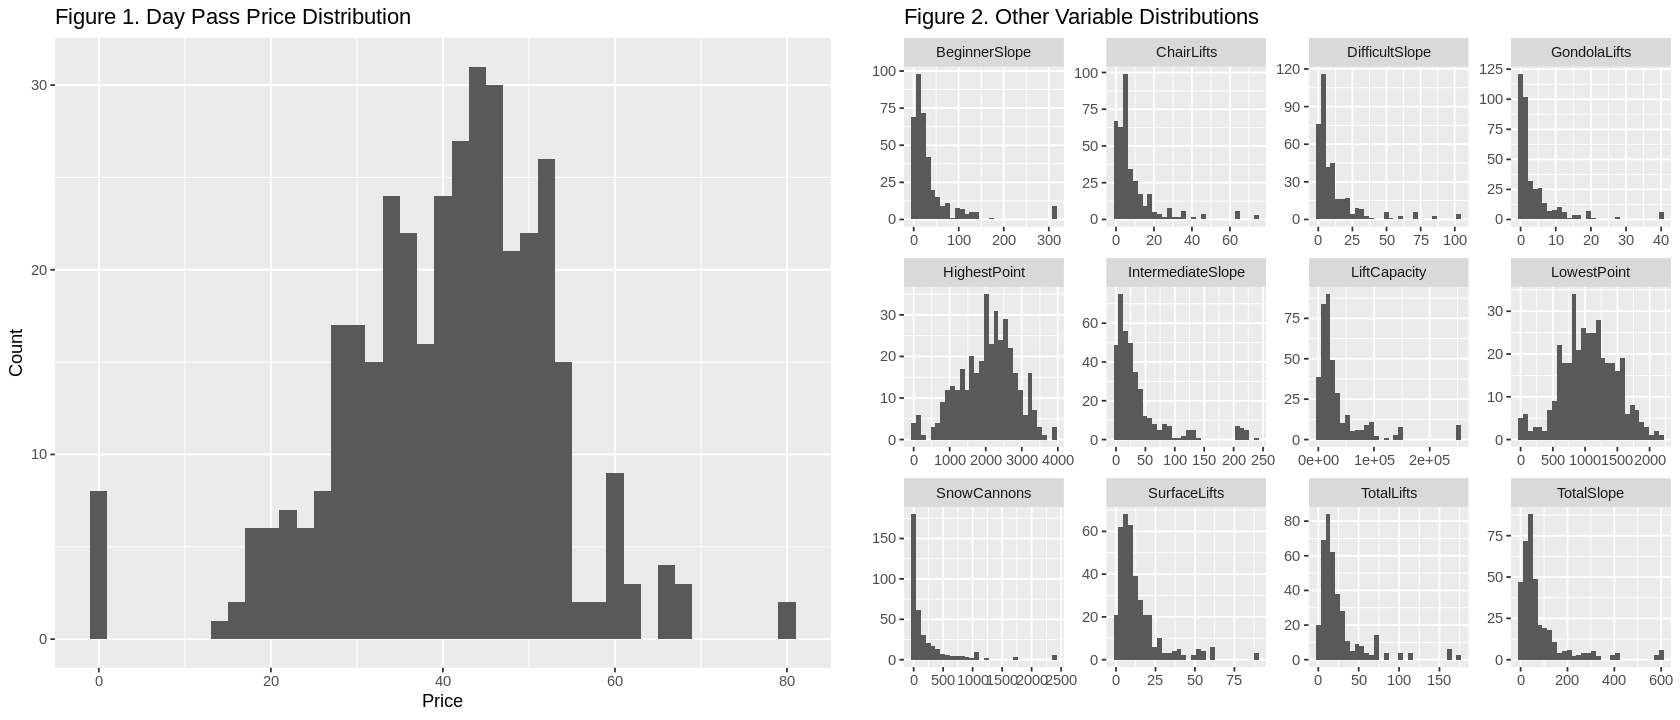

In [11]:
# Response Variable Distribution Chart
daypass_dist <- ski_data |>
    ggplot(aes(x = DayPassPriceAdult)) +
    geom_histogram(binwidth = 2) +
    labs(title = "Figure 1. Day Pass Price Distribution", x = "Price", y = "Count")

# Other Variable Distributions Chart
other_eda_dists <- ski_data |>
    keep(is.numeric) |>
    select(-DayPassPriceAdult) |>
    gather() |>
    ggplot(aes(value)) +
    facet_wrap(~ key, scales = "free") +
    geom_histogram() +
    labs(title = "Figure 2. Other Variable Distributions", x = "", y = "")

options(repr.plot.width = 14, repr.plot.height = 6)
plot_grid(daypass_dist, other_eda_dists, ncol = 2)

Here we use plot_grid() to get a sense of the relationship between our contributing factors and the price of day passes.

In [12]:
# Correlation with Day Pass Price of Major Variables of Interest
ski_correlation <- ski_data |>
    select(DayPassPriceAdult, HighestPoint, LowestPoint,  
           TotalSlope, TotalLifts, LiftCapacity, SnowCannons) |>
    cor() |>
    round(3) 
    
ski_correlation[1,2:7]

HighestPoint  LowestPoint   TotalSlope   TotalLifts LiftCapacity  SnowCannons 
       0.533        0.202        0.509        0.463        0.463        0.391

From our plot_grid we grabbed the categories that we felt best represented the main parts of ski resorts that also held noticable relations with the pass price. from there we determined their corelations through the cor() function.

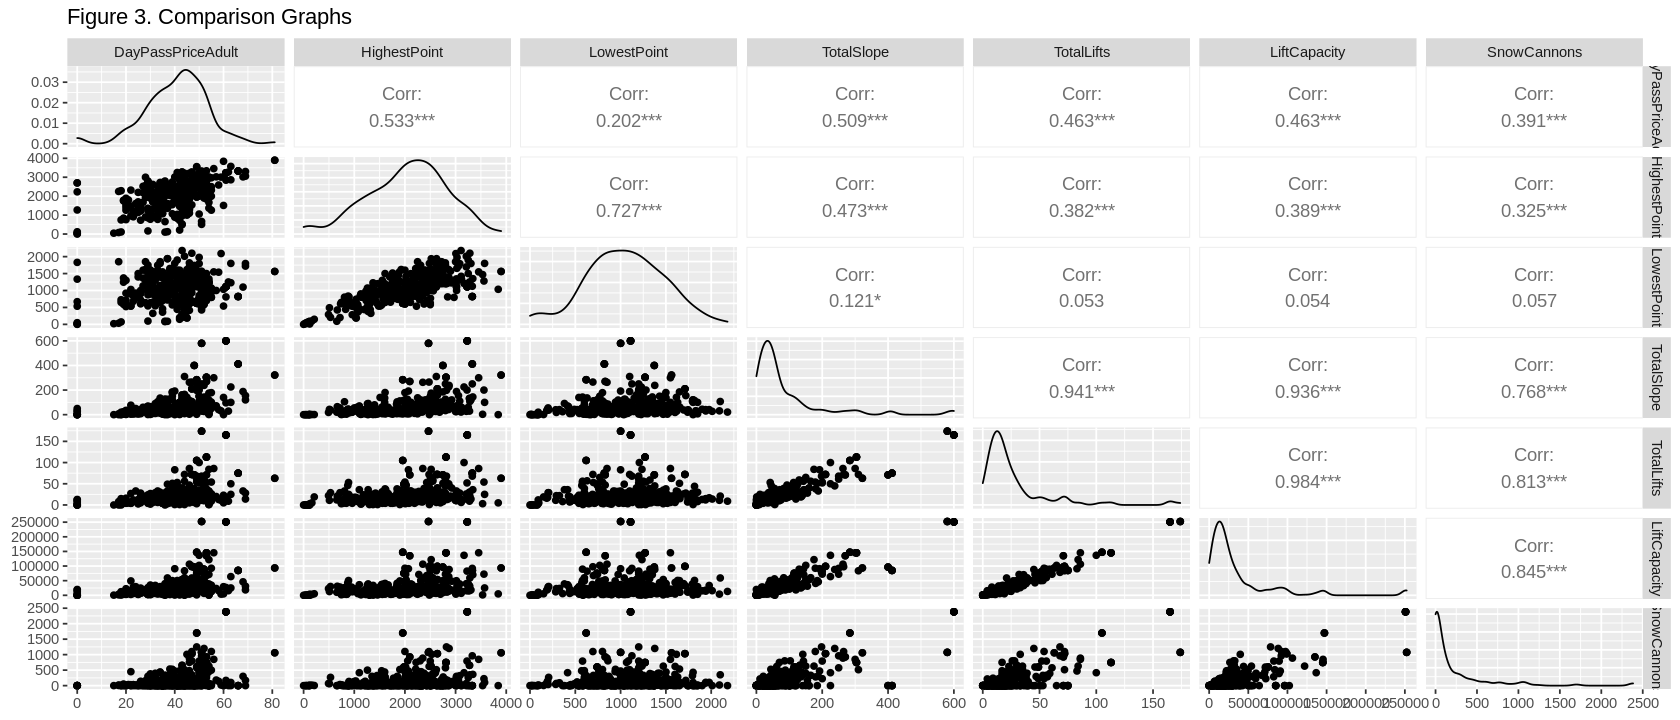

In [27]:
ggpairs(ski_data|>select(DayPassPriceAdult, HighestPoint, LowestPoint, TotalSlope, TotalLifts, LiftCapacity, SnowCannons))+ggtitle("Figure 3. Comparison Graphs")

After this we used ggpairs to examine their general relationships with the adult day pass price and proceeded to our regression model.

### Data Analysis

In [3]:
set.seed(5555)

workable_data <- ski_data |>
                select(DayPassPriceAdult, HighestPoint, LowestPoint, TotalSlope, TotalLifts, LiftCapacity, SnowCannons)|>
                keep(is.numeric)

ski_split <- initial_split(workable_data, prop = 0.70, strata = DayPassPriceAdult)  
ski_train <- training(ski_split)
ski_test <- testing(ski_split)

gridvals <- tibble(neighbors = seq(1, 10, 1))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression")

Here we used our selected our workable data through using the numeric values of the categories found above. Then we did our initial split with 70% and began our regression.

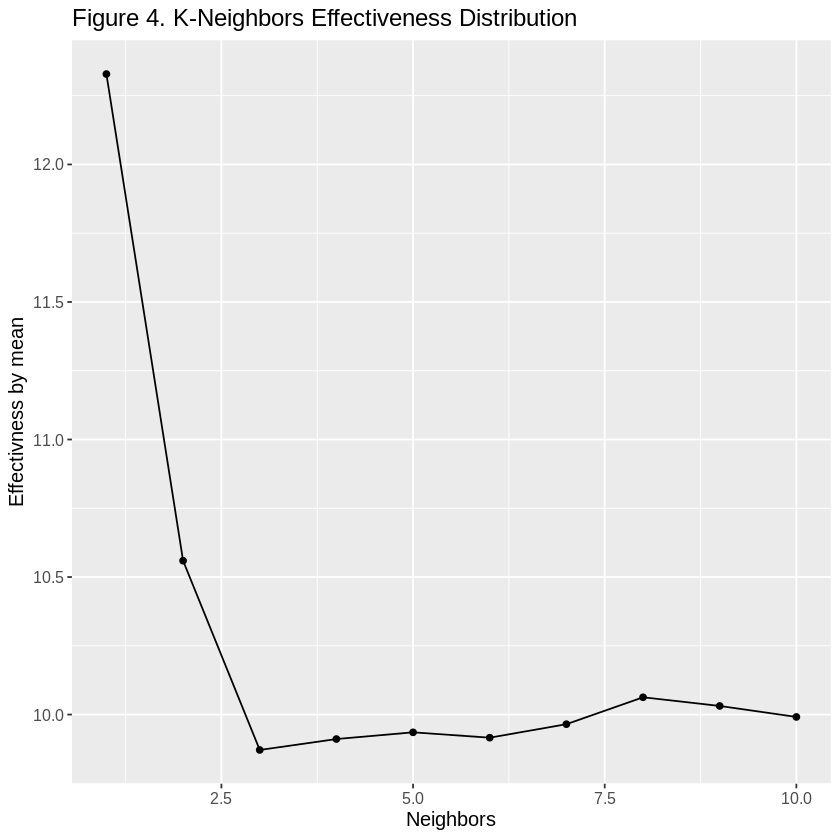

In [7]:
ski_vfold <- vfold_cv(ski_train, v = 5, strata = DayPassPriceAdult)
ski_recipe <- recipe(DayPassPriceAdult ~ ., data = ski_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

ski_fit <- workflow() |> 
           add_recipe(ski_recipe) |>
           add_model(knn_spec) |>
           tune_grid(resamples = ski_vfold, grid = gridvals) |>
           collect_metrics()|>
           filter(.metric == "rmse")

ggplot(ski_fit, aes(x=neighbors,y=mean))+
        geom_point()+
        geom_line()+
        labs(x="Neighbors",y="Effectivness by mean")+
        ggtitle("Figure 4. K-Neighbors Effectiveness Distribution")+
        theme(text = element_text(size = 12))

To determine our efficiency we chose the value of our vfolded workflow with the lowest mean. Although they are all very high in value, this is addressed in our discussion.

In [5]:
ski_k <- ski_fit |>
           arrange(mean) |>
           filter(mean == min(mean))|>
           pull(neighbors)

ski_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = ski_k) |>
            set_engine("kknn") |>
            set_mode("regression")

In [6]:
ski_best_fit <- workflow() |>
          add_recipe(ski_recipe) |>
          add_model(ski_spec) |>
          fit(data = ski_train)

ski_summary <- ski_best_fit |>
           predict(ski_test) |>
           bind_cols(ski_test) |>
           metrics(truth = DayPassPriceAdult, estimate = .pred)

ski_preds <- ski_best_fit |>
           predict(ski_train)|>
           bind_cols(ski_train)

ski_preds_compare <- ski_preds |>
                    select(.pred,DayPassPriceAdult)
"Figure 5. Predicted Price vs Actual Price"
ski_preds_compare

[1] "Figure 5. Predicted Price vs Actual Price"

.pred,DayPassPriceAdult
<dbl>,<dbl>
39.42857,22
25.57143,23
32.28571,18
37.28571,20
31.57143,22
30.42857,19
28.42857,22
38.57143,34
26.14286,25


Finally we used the best k value we found (7), for our ski prediction model and checked all of our values.

### Data Analysis Visualization

Here we graphed all of our relationships to understand our mean value.

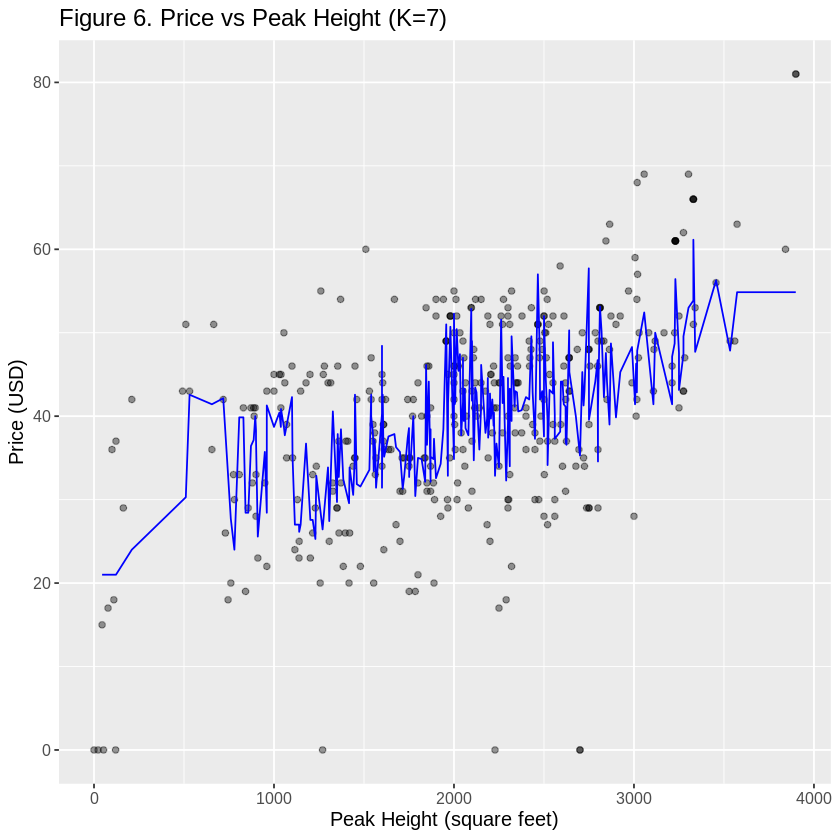

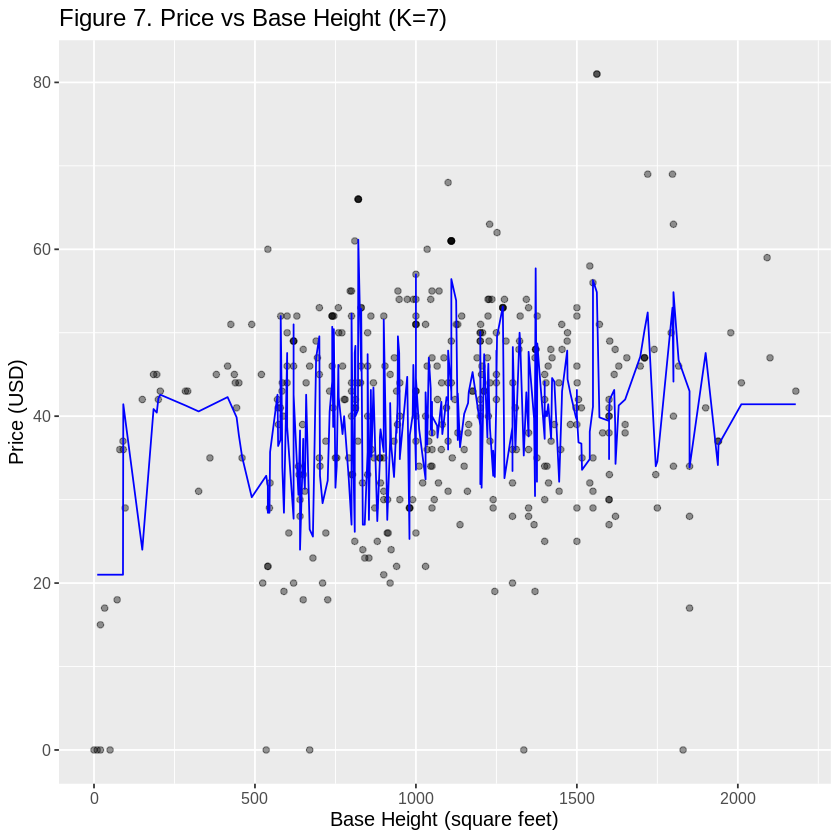

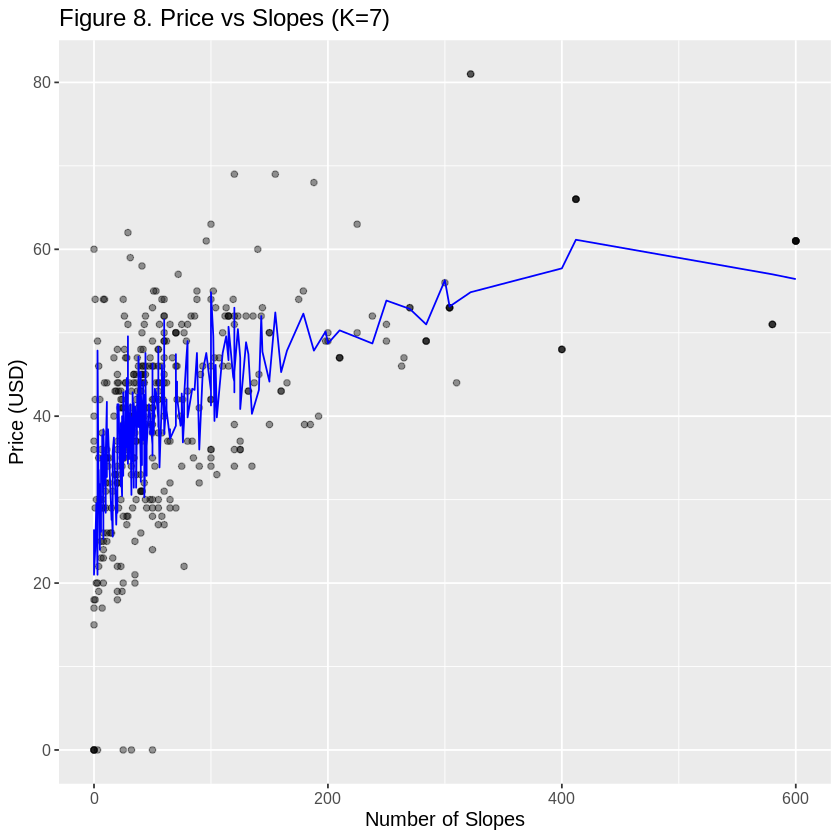

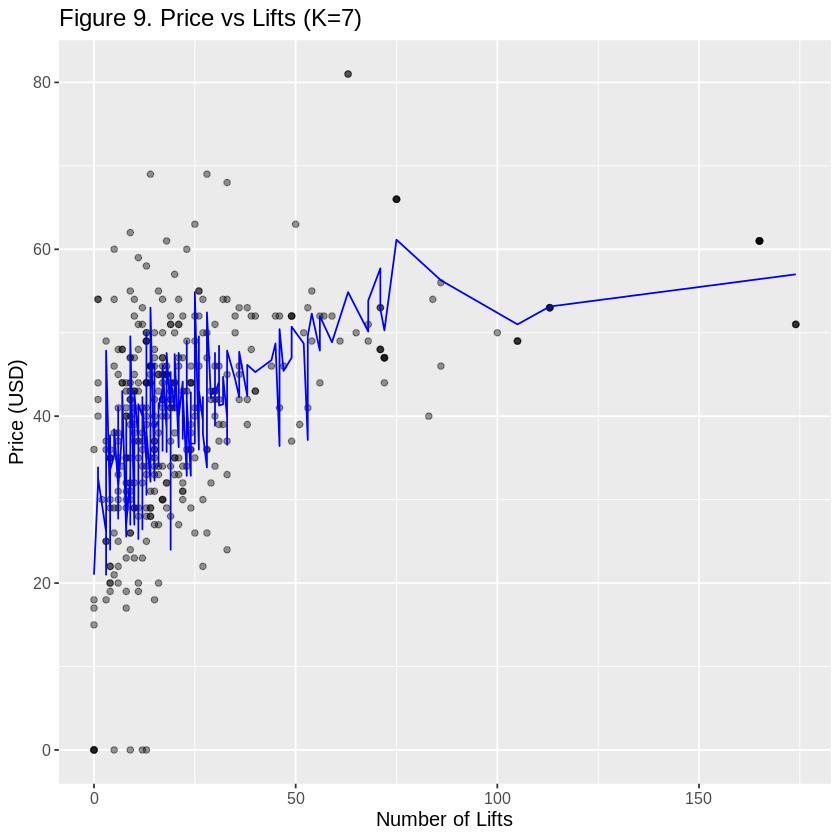

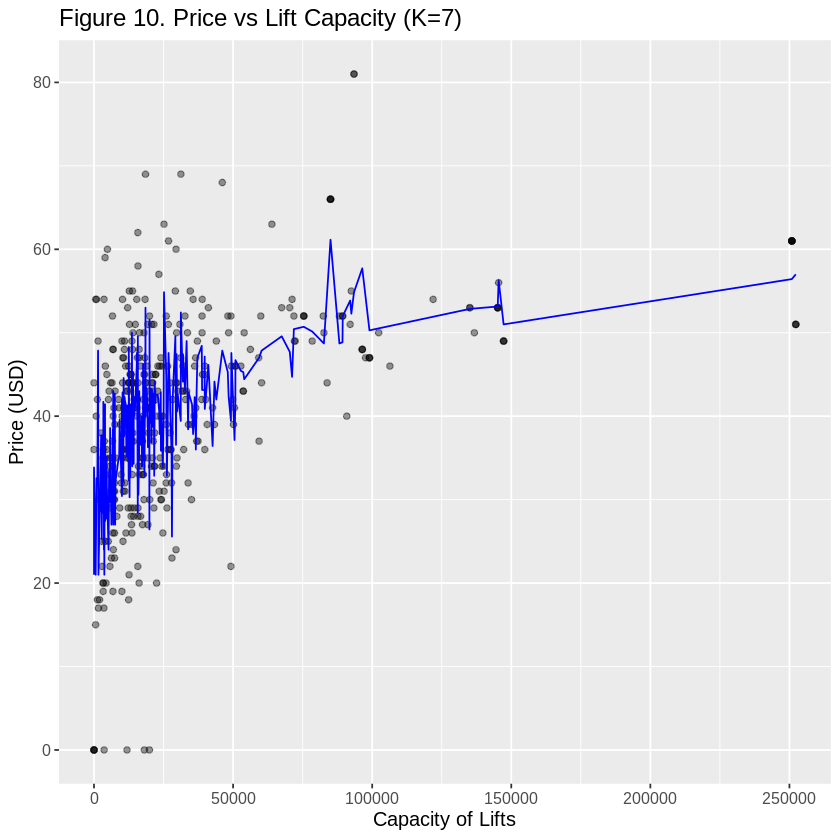

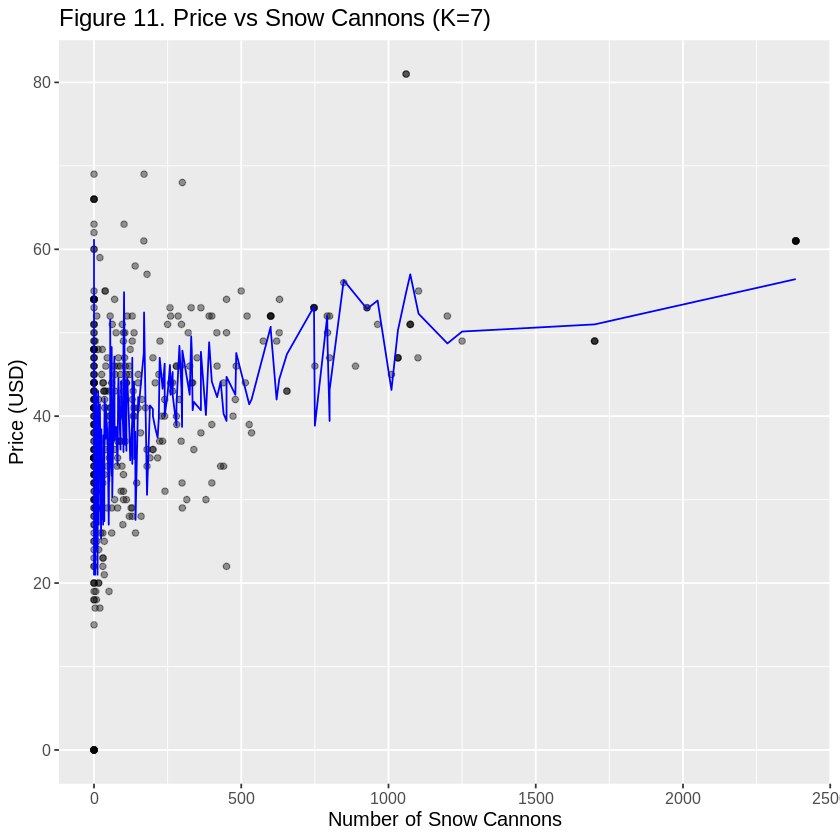

In [8]:
#individual plots for each variable
ggplot(workable_data, aes(x = HighestPoint, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = HighestPoint, y = .pred), 
            color = "blue") +
  xlab("Peak Height (square feet)") +
  ylab("Price (USD)") +
  ggtitle("Figure 6. Price vs Peak Height (K=7)") + 
  theme(text = element_text(size = 12))

ggplot(workable_data, aes(x = LowestPoint, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = LowestPoint, y = .pred), 
            color = "blue") +
  xlab("Base Height (square feet)") +
  ylab("Price (USD)") +
  ggtitle("Figure 7. Price vs Base Height (K=7)") + 
  theme(text = element_text(size = 12))

ggplot(workable_data, aes(x = TotalSlope, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = TotalSlope, y = .pred), 
            color = "blue") +
  xlab("Number of Slopes") +
  ylab("Price (USD)") +
  ggtitle("Figure 8. Price vs Slopes (K=7)") + 
  theme(text = element_text(size = 12))

ggplot(workable_data, aes(x = TotalLifts, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = TotalLifts, y = .pred), 
            color = "blue") +
  xlab("Number of Lifts") +
  ylab("Price (USD)") +
  ggtitle("Figure 9. Price vs Lifts (K=7)") + 
  theme(text = element_text(size = 12))

ggplot(workable_data, aes(x = LiftCapacity, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = LiftCapacity, y = .pred), 
            color = "blue") +
  xlab("Capacity of Lifts") +
  ylab("Price (USD)") +
  ggtitle("Figure 10. Price vs Lift Capacity (K=7)") + 
  theme(text = element_text(size = 12))

ggplot(workable_data, aes(x = SnowCannons, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = SnowCannons, y = .pred), 
            color = "blue") +
  xlab("Number of Snow Cannons") +
  ylab("Price (USD)") +
  ggtitle("Figure 11. Price vs Snow Cannons (K=7)") + 
  theme(text = element_text(size = 12))

## Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

Through our regression model we expected to see a strong relationship between the price of a day pass for adults and factors such as number of Slopes or the existence of snow cannons. We expected there to be a strong reason for the price of day passes as they can vary so from as little as 15 USD to over 80 USD in our data. Given most skiers seek larger mountains, more runs and more snow, we predicted Peak Height and Number of Slopes and Snow Cannons to be the most impactful out of all of the data.

We were amazed to find that most categories had very little effect on the price of day passes at all. The unlinked nature of this data caused nightmares in the creation of our regression model as there was weak correlation between most of our categories. Even testing a larger number of *k* neighbors still netted a similar level of model effectiveness to the *k* we've chosen to use in the model above. In the end our std_err came out to nearly 20%! However, of the three categories we had hope for, two came through for us. The Peak Height and the Number of Slopes had a visible positive relationship with our day pass price.

Such findings indicates that most of the prices are more arbitrarily decided upon that we thought. While ski resorts do require runs, elevation and facilites to charge their prices, those factors seem to have little, if no correlations to the final decided price for the lift tickets.

Questions:
- If the number of existing ski resorts decreases, will prices increase further?
- If more ski resorts are created, will prices gain a stronger relation to the aspects/facilities of the hill?
- How can lift ticket prices be maximized while facilites are minimized?

## References

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
* Make sure to cite the source of your data as well.

Dataset Source: https://www.kaggle.com/datasets/thomasnibb/european-ski-resorts

todo: write this